In [2]:
#@title Pre-Requisistes
#@title Installing the Hugging Face PyTorch Interface for Bert
!pip install -q transformers
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

##Specifying CUDA as the device for torch

In [3]:
#@title Hardware verification and device attribution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Mon Jul 11 11:19:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Loading the dataset

In [4]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0   729k      0 --:--:-- --:--:-- --:--:--  728k


In [5]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  47828      0 --:--:-- --:--:-- --:--:-- 47828


In [6]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [7]:
df.sample(10)

,sentence_source,label,label_notes,sentence
4707,ks08,1,NaN,frances has had her clean the drapes .
3243,l-93,1,NaN,tony bent the rod with pliers .
3105,l-93,1,NaN,cynthia gobbled the pizza .
1763,r-67,0,*,i have john 's to grade paper .
2590,l-93,1,NaN,jessica loaded boxes into the wagon .
8050,ad03,1,NaN,the reading of shakespeare satisfied me
4884,ks08,0,*,pictures of whom appeared in the newspaper ?
1998,rhl07,1,NaN,leigh threw the ball to lane .
232,cj99,0,*,"when bill smokes , all the more susan hates him ."
3714,ks08,1,NaN,john sang a song and danced to the music .


##Creating sentences, label lists, and adding BERT tokens
The program will now create the sentences as described in the Preparing the pretraining input environment section of this chapter:

In [8]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

##Activating the BERT tokenizer
In this section, we will initialize a pretrained BERT tokenizer. This will save the time it would take to train it from scratch.

The program selects an uncased tokenizer, activates it, and displays the first tokenized sentence:

In [9]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


##Processing the data
We need to determine a fixed maximum length and process the data for the model. The sentences in the datasets are short. But, to make sure of this, the program sets the maximum length of a sequence to 128, and the sequences are padded:



In [10]:
#@title Processing the data
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

##Creating attention masks
Now comes a tricky part of the process. We padded the sequences in the previous cell. But we want to prevent the model from performing attention to those padded tokens!

The idea is to apply a mask with a value of 1 for each token, which 0s will follow for padding:



In [11]:
#@title Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

##Splitting the data into training and validation sets
The program now performs the standard process of splitting the data into training and validation sets:

In [12]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

##Converting all the data into torch tensors

In [13]:
#@title Converting all the data into torch tensors
# Torch tensors are the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


##Selecting a batch size and creating an iterator
In this cell, the program selects a batch size and creates an iterator. The iterator is a clever way of avoiding a loop that would load all the data in memory. The iterator, coupled with the torch DataLoader, can batch train massive datasets without crashing the machine’s memory.

In this model, the batch size is 32:

In [14]:
#@title Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##BERT model configuration
The program now initializes a BERT uncased configuration:

In [15]:
#@title BERT Model Configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  
from transformers import BertModel, BertConfig
configuration = BertConfig()
# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



##Loading the Hugging Face BERT uncased base model

In [17]:
#@title Loading the Hugging Face Bert uncased base model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

##Optimizer grouped parameters

In [18]:
##@title Optimizer Grouped Parameters
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have 'gamma' or 'beta' parameters, only 'bias' terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the 'weight' parameters from the 'bias' parameters. 
# - For the 'weight' parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the 'bias' parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - 'optimizer_grouped_parameters' only includes the parameter values, not the names.

##The hyperparameters for the training loop
The hyperparameters for the training loop are critical, though they seem innocuous. Adam will activate weight decay and also go through a warm-up phase, for example.

The learning rate (lr) and warm-up rate (warmup) should be set to a very small value early in the optimization phase and gradually increase after a certain number of iterations. This avoids large gradients and overshooting the optimization goals.

Some researchers argue that the gradients at the output level of the sub-layers before layer normalization do not require a warm-up rate. Solving this problem requires many experimental runs.

The optimizer is a BERT version of Adam called BertAdam:

In [19]:
#@title The Hyperparameters for the Training Loop 
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

##The training loop

In [22]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5133115372222489


Epoch:  25%|██▌       | 1/4 [02:35<07:46, 155.51s/it]

Validation Accuracy: 0.8117283950617284
Train loss: 0.3286580163289897


Epoch:  50%|█████     | 2/4 [05:12<05:13, 156.57s/it]

Validation Accuracy: 0.8163580246913581
Train loss: 0.19907331602702003


Epoch:  75%|███████▌  | 3/4 [07:50<02:36, 156.90s/it]

Validation Accuracy: 0.8302469135802469
Train loss: 0.13025399785164232


Epoch: 100%|██████████| 4/4 [10:27<00:00, 156.92s/it]

Validation Accuracy: 0.8267746913580247


##Training evaluation
The loss and accuracy values were stored in train_loss_set as defined at the beginning of the training loop.

The program now plots the measurements:

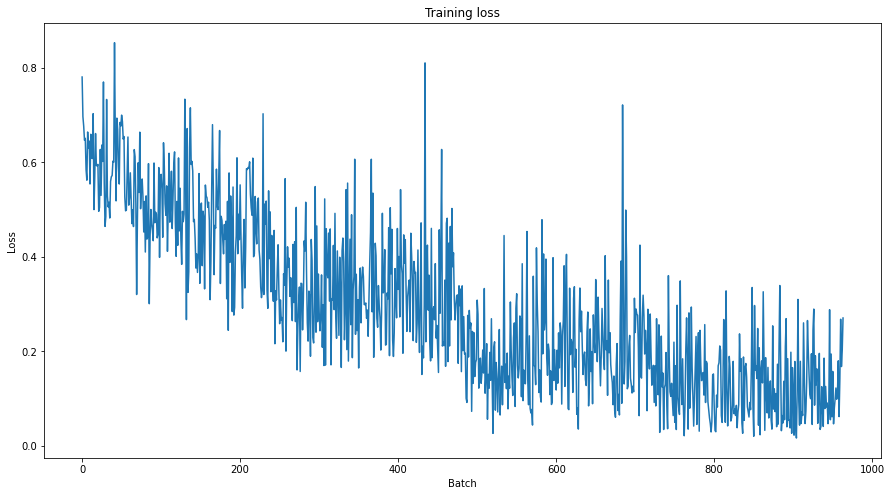

In [23]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predicting and evaluating using the holdout dataset

In [24]:
#@title Predicting and Evaluating Using the Holdout Dataset 
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [25]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

##Evaluating using the Matthews Correlation Coefficient
The Matthews Correlation Coefficient (MCC) was initially designed to measure the quality of binary classifications and can be modified to be a multi-class correlation coefficient. A two-class classification can be made with four probabilities at each prediction:

TP = True Positive
TN = True Negative
FP = False Positive
FN = False Negative
Brian W. Matthews, a biochemist, designed it in 1975, inspired by his predecessors’ phi function. Since then, it has evolved into various formats such as the following one:



The value produced by MCC is between -1 and +1. +1 is the maximum positive value of a prediction. -1 is an inverse prediction. 0 is an average random prediction.

GLUE evaluates Linguistic Acceptability with MCC.

MCC is imported from sklearn.metrics:

In [26]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

##The scores of individual batches

In [27]:
#@title Score of Individual Batches
matthews_set

[-0.14856415213808927,
 -0.21684543705982773,
 0.4040950971038548,
 0.30508307783296046,
 0.5222329678670935,
 0.6777932975034471,
 0.4472135954999579,
 0.47519096331149147,
 1.0,
 0.8246211251235321,
 0.9229582069908973,
 0.6666666666666666,
 0.8150678894028793,
 0.8320502943378436,
 0.38461538461538464,
 0.5716350506349809,
 0.0]

##Matthews evaluation for the whole dataset

In [28]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5603956593985039

##Summary
BERT brings bidirectional attention to transformers. Predicting sequences from left to right and masking the future tokens to train a model has serious limitations. If the masked sequence contains the meaning we are looking for, the model will produce errors. BERT attends to all of the tokens of a sequence at the same time.

We explored the architecture of BERT, which only uses the encoder stack of transformers. BERT was designed as a two-step framework. The first step of the framework is to pretrain a model. The second step is to fine-tune the model. We built a fine-tuning BERT model for an Acceptability Judgment downstream task. The fine-tuning process went through all phases of the process. First, we loaded the dataset and loaded the necessary pretrained modules of the model. Then the model was trained, and its performance was measured.

Fine-tuning a pretrained model takes fewer machine resources than training downstream tasks from scratch. Fine-tuned models can perform a variety of tasks. BERT proves that we can pretrain a model on two tasks only, which is remarkable in itself. But producing a multitask fine-tuned model based on the trained parameters of the BERT pretrained model is extraordinary.